In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time
import shutil

## Style sheet
plt.style.use("seaborn-v0_8-paper")
latex_installed = shutil.which("latex") is not None

rcparams = {
    "text.usetex": latex_installed,
    "font.size": 12,
    "lines.linewidth": 2,
    "mathtext.fontset": "cm", 
}

if latex_installed:
    rcparams["text.latex.preamble"] = r"\usepackage{amsmath}"
    rcparams["font.family"] = "cmu serif"
else:
    rcparams["font.family"] = "serif"

plt.rcParams.update(rcparams)

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]


## Import data, setup 

In [8]:
from data.uzh_sample_data.extract_uzh_mav_data import extract_real_data
from src.algorithms import IMMCV, RGPMT_ND, MMRGP
from src.utils import sq_exp_kernel, matern_kernel

extract_real_data(meas_drop_rate=0.95, seed=471)
data = np.load("./data/uzh_sample_data/data.npz")

time_steps = data["time"]
true_x = data["true_x"]
true_y = data["true_y"]
meas_x = data["meas_x"]
meas_y = data["meas_y"]
mask = data["mask"]


num_time_steps = len(time_steps)
num_measurements = np.sum(mask)
q_levels = np.array([1.0, 2.0, 4.0, 8.0, 16.0])*1e-1
length_scales = np.array([1.0, 3.0, 5.0, 7.0, 9.0]) * 50
r = 5.0
num_models = len(q_levels)
num_states = 25
kernel = matern_kernel
theta_init = np.array([350.0, 25.0, r])

imm_cv = IMMCV(q_levels, r, time_steps[1] - time_steps[0])
rgp_mt = RGPMT_ND(num_states, time_steps[0:num_states], [meas_x[0:num_states], meas_y[0:num_states]], kernel, theta_init=theta_init)
mm_rgp = MMRGP(kernel, time_steps[-1], length_scales, r, num_states, 1e-3, 25.0)

print("Number of timesteps:", num_time_steps)
print("Number of observations:", num_measurements)

Data file already exists at data/uzh_sample_data/AGZ_subset.zip, skipping download.
Number of timesteps: 2650
Number of observations: 139


## IMM-CV on uzh data

IMM-CV total run time: 0.38 seconds for 2650 steps.
Average runtime for IMM-CV: 4.916225e-04 seconds


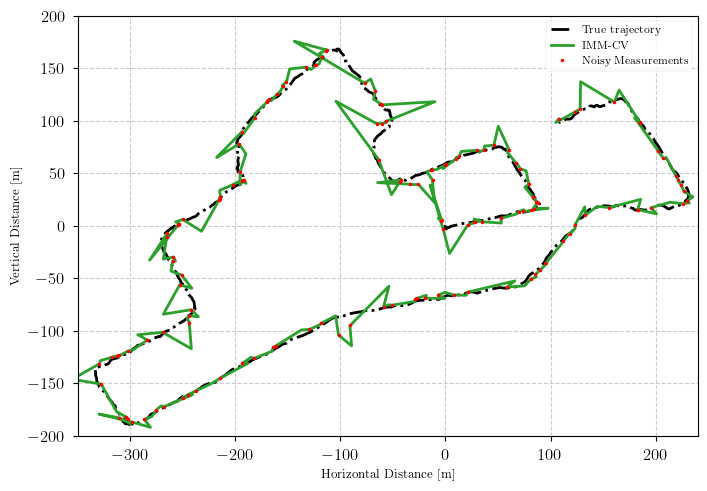

In [9]:
est_x = np.zeros(num_time_steps)
est_y = np.zeros(num_time_steps)
mode_probs = np.zeros((num_time_steps, num_models))

start = time.time()
time_list = []
for k in range(num_time_steps):
    start_time = time.time()
    z = np.array([meas_x[k], meas_y[k]])
    imm_cv.predict()
    if not np.isnan(z).any():
        imm_cv.update(z)
        delta_time = time.time() - start_time
        # print("{:e}".format(delta_time))
        time_list.append(delta_time)

    # Save estimates
    est_x[k] = imm_cv.x[0][0]
    est_y[k] = imm_cv.x[2][0]
    mode_probs[k] = imm_cv.mu

print(f"IMM-CV total run time: {time.time() - start:.2f} seconds for {num_time_steps} steps.")

print("Average runtime for IMM-CV: {:e} seconds".format(np.mean(time_list)))

error_imm_cv = (np.array(true_x) - np.array(est_x)) ** 2 + (np.array(true_y) - np.array(est_y)) ** 2

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(true_x, true_y, "k-.", label="True trajectory")
ax.plot(est_x, est_y, label="IMM-CV", color=colors[2])
ax.plot(
    meas_x,
    meas_y,
    linestyle="",
    marker=".",
    color="red",
    label="Noisy Measurements",
    markersize=5,
)
ax.set_aspect("equal")
ax.set_xlabel("Horizontal Distance [m]")
ax.set_ylabel("Vertical Distance [m]")
ax.legend()
ax.set_ylim((-200.0, 200.0))
ax.set_xlim((-350.0, 240.0))
ax.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], zorder=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("./figures/uzh_data/imm_cv.pdf", format="pdf", bbox_inches="tight")

## RGPMT on uzh data

RGP*MT total run time: 109.69 seconds for 2650 steps.
Average runtime for RGP*MT: 4.036785e-02 seconds


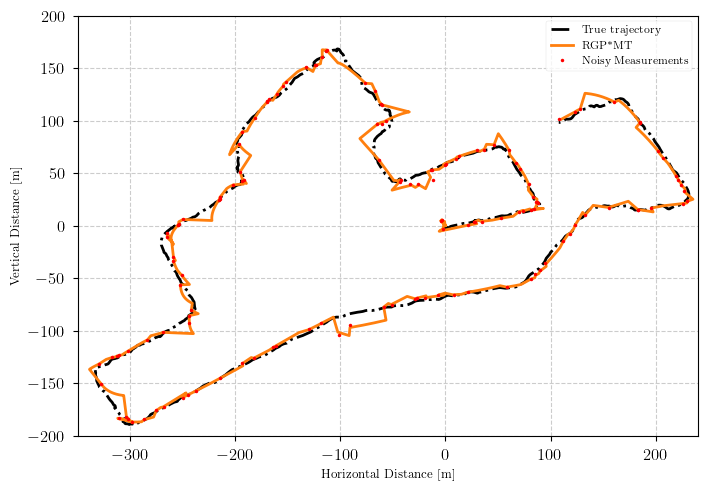

In [10]:
start = time.time()
time_list = []
for k in range(num_time_steps):
    start_time = time.time()
    z = np.array([meas_x[k], meas_y[k]])
    meas_time = time_steps[k]
    rgp_mt.step(z, meas_time)
    if not np.isnan(z).any():
        delta_time = time.time() - start_time
        time_list.append(delta_time)

print(f"RGP*MT total run time: {time.time() - start:.2f} seconds for {num_time_steps} steps.")

print("Average runtime for RGP*MT: {:e} seconds".format(np.mean(time_list)))

est_traj = rgp_mt.predicted_mean()
est_x = est_traj[0]
est_y = est_traj[1]

error_rgpmt = (np.array(true_x[:-1]) - np.array(est_x)) ** 2 + (np.array(true_y[:-1]) - np.array(est_y)) ** 2

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(true_x, true_y, "k-.", label="True trajectory")
ax.plot(est_x, est_y, label="RGP*MT", color=colors[1])
ax.plot(
    meas_x,
    meas_y,
    linestyle="",
    marker=".",
    color="red",
    label="Noisy Measurements",
    markersize=5,
)
ax.set_aspect("equal")
ax.set_xlabel("Horizontal Distance [m]")
ax.set_ylabel("Vertical Distance [m]")
ax.legend()
ax.set_ylim((-200.0, 200.0))
ax.set_xlim((-350.0, 240.0))
ax.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], zorder=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("./figures/uzh_data/rgpmt.pdf", format="pdf", bbox_inches="tight")

## MM-RGP on uzh data

IMM-RGP total run time: 0.90 seconds for 2650 steps.
Average runtime for IMM-RGP: 1.176308e-03 seconds


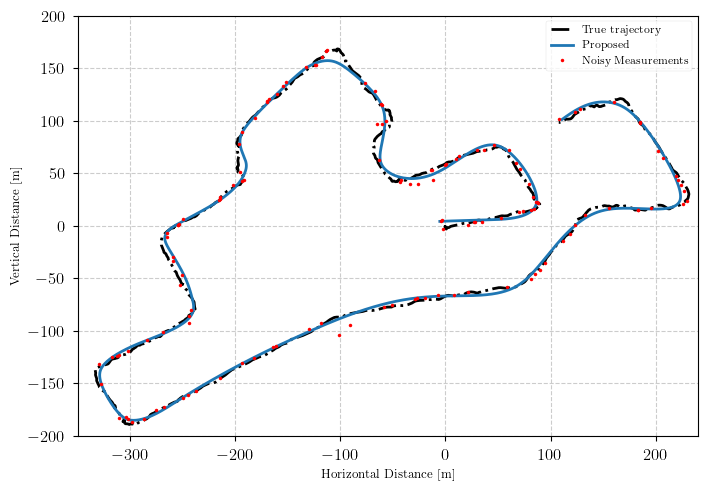

In [11]:

start = time.time()
time_list = []
for k in range(num_time_steps):
    start_time = time.time()
    z = np.array([meas_x[k], meas_y[k]])
    meas_time = time_steps[k]
    mm_rgp.time_update()
    if not np.isnan(z).any():
        mm_rgp.meas_update(z, meas_time)
        delta_time = time.time() - start_time
        time_list.append(delta_time)

est_traj = mm_rgp.predicted_mean(time_steps)
est_x = est_traj[0:num_time_steps]
est_y = est_traj[num_time_steps:]

print(f"IMM-RGP total run time: {time.time() - start:.2f} seconds for {num_time_steps} steps.")

print("Average runtime for IMM-RGP: {:e} seconds".format(np.mean(time_list)))

error_mm_rgp = ((np.array(true_x) - np.array(est_x).T) ** 2 + (np.array(true_y).T - np.array(est_y).T) ** 2).reshape((-1,))


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(true_x, true_y, "k-.", label="True trajectory")
ax.plot(est_x, est_y, label="Proposed", color=colors[0])
ax.plot(
    meas_x,
    meas_y,
    linestyle="",
    marker=".",
    color="red",
    label="Noisy Measurements",
    markersize=5,
)
ax.set_aspect("equal")
ax.set_xlabel("Horizontal Distance [m]")
ax.set_ylabel("Vertical Distance [m]")
ax.legend()
ax.set_ylim((-200.0, 200.0))
ax.set_xlim((-350.0, 240.0))
ax.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], zorder=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("./figures/uzh_data/mm_rgp.pdf", format="pdf", bbox_inches="tight")

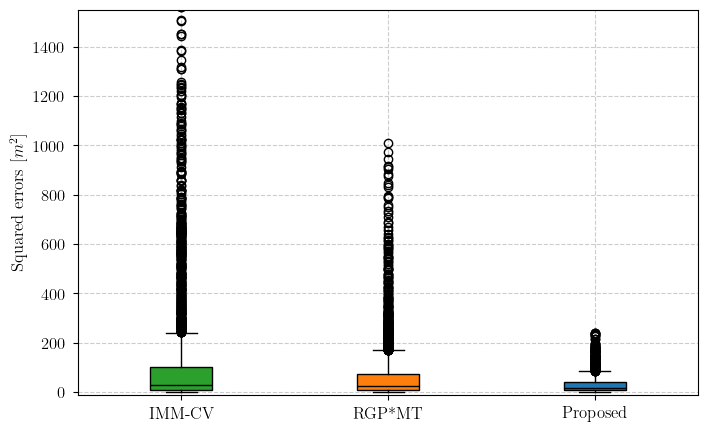

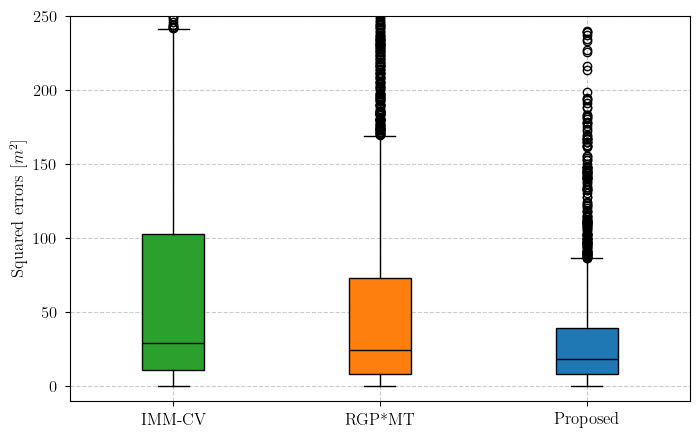

In [12]:

data = [error_imm_cv, error_rgpmt, error_mm_rgp]
labels = ["IMM-CV", "RGP*MT", "Proposed"]

# Create box plot
fig, ax = plt.subplots(figsize=(8, 5))
bplot = ax.boxplot(data, tick_labels=labels, showfliers=True, patch_artist=True)
ax.set_ylabel("Squared errors $[m^2]$", fontsize=12)
ax.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], zorder=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for i in range(len(labels)):
    bplot["boxes"][len(labels) - i - 1].set_facecolor(colors[i])

for median in bplot["medians"]:
    median.set_color("black")

ax.set_ylim((-10.0, 1550.0))
plt.savefig("./figures/uzh_data/box_plot.pdf", format="pdf", bbox_inches="tight")

# Create zoomed plot
fig, ax = plt.subplots(figsize=(8, 5))
bplot = ax.boxplot(data, tick_labels=labels, showfliers=True, patch_artist=True)
ax.set_ylabel("Squared errors $[m^2]$", fontsize=12)
ax.grid(True, linestyle="--", color=[0.8, 0.8, 0.8, 0.8], zorder=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for i in range(len(labels)):
    bplot["boxes"][len(labels) - i - 1].set_facecolor(colors[i])

for median in bplot["medians"]:
    median.set_color("black")

ax.set_ylim((-10.0, 250.0))
plt.savefig("./figures/uzh_data/box_plot_zoomed.pdf", format="pdf", bbox_inches="tight")